In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
!pip install torchsummary
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os
from tqdm import tqdm

In [2]:
class Basicblock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, dropRate):
        super(Basicblock, self).__init__()
        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )
        self.droprate = dropRate
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity =  x
        x = self.residual(x)
        if self.droprate > 0:
            x = F.dropout(x, p=self.droprate, training=self.training)
        x += self.skip(identity)
        return x

In [3]:
class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, num_classes, dropRate):
        super(WideResNet, self).__init__()
        self.in_channels = 16

        assert ((depth-4)%6 == 0)
        n = (depth-4) // 6
        k = widen_factor
#         print('|Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = nn.Conv2d(3,nStages[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._wide_layer(Basicblock, nStages[1], n, stride=1, dropRate=dropRate)
        self.layer2 = self._wide_layer(Basicblock, nStages[2], n, stride=2, dropRate=dropRate)
        self.layer3 = self._wide_layer(Basicblock, nStages[3], n, stride=2, dropRate=dropRate)
        self.bn1 = nn.BatchNorm2d(nStages[3])
        self.relu = nn.ReLU()
        self.fc = nn.Linear(nStages[3], num_classes)
        self.nStages = nStages[3]
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _wide_layer(self, block, out_channels, num_blocks, stride, dropRate):
        strides = [stride] + [1] * (int(num_blocks) - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, dropRate))
            self.in_channels = out_channels

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.relu(self.bn1(x))
        x = F.avg_pool2d(x, 8)
        x = x.view(-1, self.nStages)
        return self.fc(x)


In [4]:
model1 = WideResNet(28, 10, 10, 0.3)
model2 = WideResNet(40, 1, 10, 0.3)
random_input = torch.randn(1, 3, 32, 32)

# Pass the random input through the model
output = model1(random_input)

# Print the output
print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 10])
Output: tensor([[-0.0810,  0.0412, -0.3225, -0.0673,  0.4138, -0.0646,  0.2225,  0.0687,
         -0.1176,  0.2080]], grad_fn=<AddmmBackward0>)


In [5]:
path = '/content/sample_data'
if not os.path.exists(path):
    os.mkdir(path)

# 데이터셋 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 수평으로 뒤집기
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


# CIFAR-10
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 30618790.38it/s]


Extracting /content/sample_data/cifar-10-python.tar.gz to /content/sample_data
Files already downloaded and verified


In [6]:
# CUDA 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델2을 CUDA로 이동
model2.to(device)

# hyper parameters
initial_learning_rate = 0.1

# loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.0005)

# scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120], gamma=0.1)

In [7]:
def model_train(model2, data_loader, criterion, optimizer, epoch):
    model2.train()

    global epoch_step
    running_size, running_loss, correct = 0.0, 0.0, 0.0

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        pbar = tqdm(data_loader)
    else:
        pbar = data_loader

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_size += images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar.set_description('[Training] loss: ' +
                                f'{running_loss / running_size:.4f}, accuracy: ' +
                                f'{correct / running_size:.4f}')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    avg_accuracy = correct / running_size
    avg_loss = running_loss / running_size

    # Train Error Rate 계산
    train_error_rate = 100 * (1 - avg_accuracy)

    # Train Error Rate 출력 (epoch_step에 따라)
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f'Train Error Rate: {train_error_rate:.2f}%')

    return avg_loss, avg_accuracy, train_error_rate

def model_eval(model2, data_loader, criterion, epoch):
    model2.eval()
    with torch.no_grad():
        running_loss, correct = 0.0, 0.0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar = tqdm(data_loader)
        else:
            pbar = data_loader

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            pred = outputs.argmax(dim=1)

            correct += torch.sum(pred == labels).item()
            running_loss += criterion(outputs, labels).item() * images.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)

        # Test Error Rate 계산
        test_error_rate = 100 * (1 - accuracy)

        # Test Error Rate 출력 (epoch_step에 따라)
        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            print(f'Test Error Rate: {test_error_rate:.2f}%')

        return loss, accuracy, test_error_rate

In [8]:
# 모델 학습 및 평가 코드
loss, accuracy, train_error_rates, test_error_rates = [], [], [], []
num_epochs = 200
epoch_step = 20

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_error_rate = model_train(model2, trainloader, criterion, optimizer, epoch)
    test_loss, test_accuracy, test_error_rate = model_eval(model2, testloader, criterion, epoch)

    loss.append([train_loss, test_loss])
    accuracy.append([train_accuracy, test_accuracy])
    train_error_rates.append(train_error_rate)
    test_error_rates.append(test_error_rate)

    scheduler.step()  # 스케줄러 업데이트

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}, Training loss: " +
              f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")
        print(f"Train error rate: {train_error_rate:.2f}%, Test error rate: {test_error_rate:.2f}%")


[Training] loss: 1.7194, accuracy: 0.3450: 100%|██████████| 391/391 [00:44<00:00,  8.85it/s]


Train Error Rate: 65.50%


100%|██████████| 79/79 [00:04<00:00, 18.73it/s]

Test Error Rate: 54.22%
epoch 001, Training loss: 1.7194, Training accuracy: 0.3450
Test loss: 1.5327, Test accuracy: 0.4578
Train error rate: 65.50%, Test error rate: 54.22%



[Training] loss: 0.5602, accuracy: 0.8065: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s]


Train Error Rate: 19.35%


100%|██████████| 79/79 [00:05<00:00, 14.59it/s]

Test Error Rate: 20.09%
epoch 020, Training loss: 0.5602, Training accuracy: 0.8065
Test loss: 0.6038, Test accuracy: 0.7991
Train error rate: 19.35%, Test error rate: 20.09%



[Training] loss: 0.5031, accuracy: 0.8272: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]


Train Error Rate: 17.28%


100%|██████████| 79/79 [00:04<00:00, 18.20it/s]

Test Error Rate: 21.41%
epoch 040, Training loss: 0.5031, Training accuracy: 0.8272
Test loss: 0.6210, Test accuracy: 0.7859
Train error rate: 17.28%, Test error rate: 21.41%



[Training] loss: 0.4869, accuracy: 0.8317: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]


Train Error Rate: 16.83%


100%|██████████| 79/79 [00:04<00:00, 18.14it/s]

Test Error Rate: 20.13%
epoch 060, Training loss: 0.4869, Training accuracy: 0.8317
Test loss: 0.5917, Test accuracy: 0.7987
Train error rate: 16.83%, Test error rate: 20.13%



[Training] loss: 0.2015, accuracy: 0.9305: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]


Train Error Rate: 6.95%


100%|██████████| 79/79 [00:05<00:00, 13.65it/s]

Test Error Rate: 9.89%
epoch 080, Training loss: 0.2015, Training accuracy: 0.9305
Test loss: 0.2989, Test accuracy: 0.9011
Train error rate: 6.95%, Test error rate: 9.89%



[Training] loss: 0.1913, accuracy: 0.9335: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s]


Train Error Rate: 6.65%


100%|██████████| 79/79 [00:05<00:00, 15.73it/s]

Test Error Rate: 9.96%
epoch 100, Training loss: 0.1913, Training accuracy: 0.9335
Test loss: 0.3048, Test accuracy: 0.9004
Train error rate: 6.65%, Test error rate: 9.96%



[Training] loss: 0.1894, accuracy: 0.9342: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s]


Train Error Rate: 6.58%


100%|██████████| 79/79 [00:04<00:00, 18.14it/s]

Test Error Rate: 10.48%
epoch 120, Training loss: 0.1894, Training accuracy: 0.9342
Test loss: 0.3248, Test accuracy: 0.8952
Train error rate: 6.58%, Test error rate: 10.48%



[Training] loss: 0.0751, accuracy: 0.9743: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]


Train Error Rate: 2.57%


100%|██████████| 79/79 [00:04<00:00, 18.23it/s]

Test Error Rate: 7.13%
epoch 140, Training loss: 0.0751, Training accuracy: 0.9743
Test loss: 0.2422, Test accuracy: 0.9287
Train error rate: 2.57%, Test error rate: 7.13%



[Training] loss: 0.0635, accuracy: 0.9779: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


Train Error Rate: 2.21%


100%|██████████| 79/79 [00:05<00:00, 14.15it/s]

Test Error Rate: 7.13%
epoch 160, Training loss: 0.0635, Training accuracy: 0.9779
Test loss: 0.2579, Test accuracy: 0.9287
Train error rate: 2.21%, Test error rate: 7.13%



[Training] loss: 0.0546, accuracy: 0.9821: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]


Train Error Rate: 1.79%


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]

Test Error Rate: 7.13%
epoch 180, Training loss: 0.0546, Training accuracy: 0.9821
Test loss: 0.2639, Test accuracy: 0.9287
Train error rate: 1.79%, Test error rate: 7.13%



[Training] loss: 0.0518, accuracy: 0.9828: 100%|██████████| 391/391 [00:37<00:00, 10.45it/s]


Train Error Rate: 1.72%


100%|██████████| 79/79 [00:04<00:00, 16.72it/s]

Test Error Rate: 7.06%
epoch 200, Training loss: 0.0518, Training accuracy: 0.9828
Test loss: 0.2609, Test accuracy: 0.9294
Train error rate: 1.72%, Test error rate: 7.06%


RuntimeError: Parent directory /kaggle/working/data does not exist.

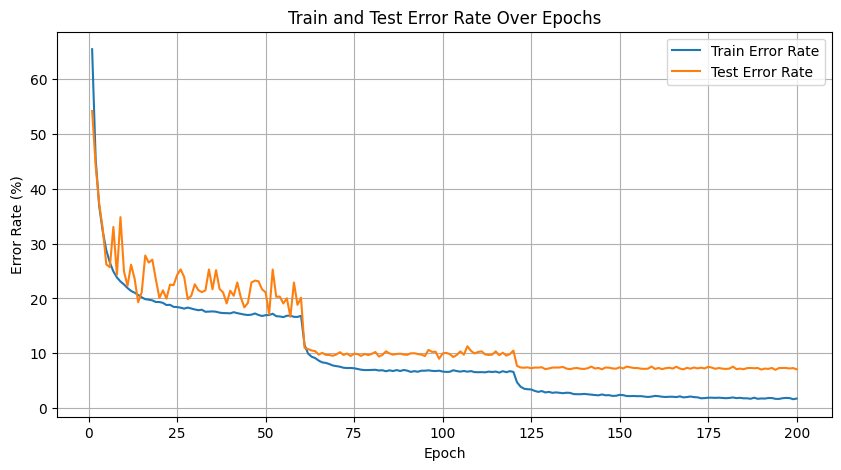

In [9]:
# 모델 상태 저장

# Train Error Rate와 Test Error Rate 그림 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_error_rates, label='Train Error Rate')
plt.plot(range(1, num_epochs + 1), test_error_rates, label='Test Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate (%)')
plt.title('Train and Test Error Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

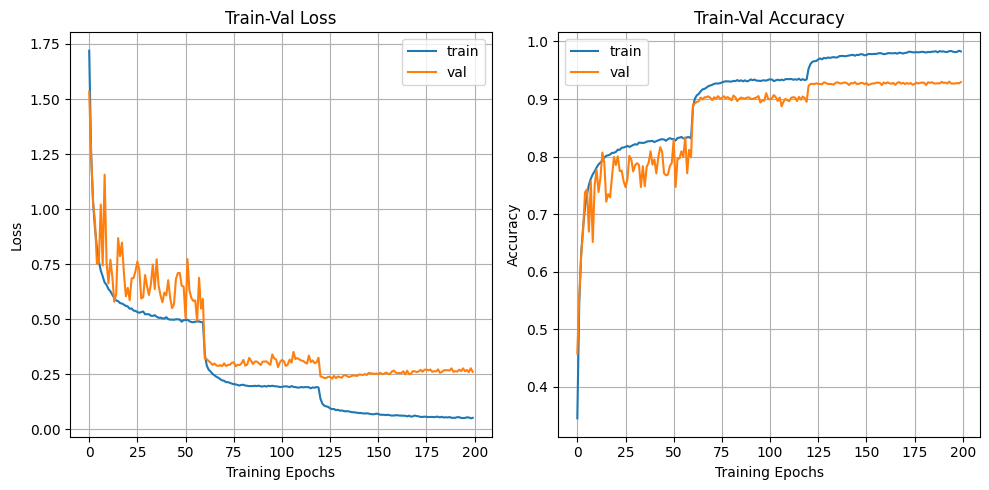

In [12]:
import matplotlib.pyplot as plt

# 손실 그래프
train_losses, val_losses = zip(*loss)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Train-Val Loss')

# 정확도 그래프
train_accuracies, val_accuracies = zip(*accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train-Val Accuracy')

plt.tight_layout()
plt.grid(True)
plt.show()